In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pingouin import welch_anova, pairwise_gameshowell, pairwise_ttests, anova
from scipy.stats import chi2,ttest_ind, mannwhitneyu, levene,bartlett, f_oneway,kruskal, shapiro, anderson, normaltest, chisquare
%matplotlib inline

In [2]:
bus=pd.read_csv('bus-breakdown-and-delays.csv')
bus2=bus.copy()

C:\Users\catin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



# NIKO

In [3]:
def minutes(x): # mencari angka berurut untuk diubah ke menit
    flag = None
    num_list = list()
    num = str()
    for i in str(x):         
        if i.isnumeric():
            flag = 1
            num += i
        else:
            if num:
                num_list.append(num)
            flag = 0
            num = ''
    return int(num_list[-1]) if num_list else 0

bus['How_Long_Delayed'] = bus.How_Long_Delayed.fillna(0) # NaN sama dengan 0
bus['How_Long_Delayed'] = bus.How_Long_Delayed.str.lower()
bus['HLD'] = pd.to_numeric(bus.How_Long_Delayed, errors='coerce') # membuat column baru bernama HLD

bus.loc[
    bus.How_Long_Delayed.str.contains('m|-|in|/', na=False), 
    'HLD'
] = bus.How_Long_Delayed.apply(minutes) # apabila di column How_Long_Delayed terdapat string (m,-,in,/) maka apply minutes
bus.loc[bus.How_Long_Delayed.str.contains('hr|hour', na=False), 'HLD'] = 60 # apabila ada string (hr,hour)
bus.loc[bus.HLD.isna(), 'HLD'] = 0 # error atau NaN sama dengan 0
bus.loc[bus.Breakdown_or_Running_Late =='Breakdown', 'HLD'] = 0 # bus yang breakdown tidak dianggap delay (sama dengan 0)

In [4]:
lis = []
for i in bus['HLD'].values:
    if i == 0.0:
        lis.append('0')
    elif i >= 0.1 and i <= 15.0:
        lis.append('0.1 - 15.0')
    elif i >= 15.1 and i <= 30.0:
        lis.append ('15.1 - 30.0')
    elif i >= 30.1 and i <= 45.0:
        lis.append('30.1 - 45.0')
    elif i >= 45.1 and i <= 60.0:
        lis.append('45.1 - 60.0')
    elif i >= 60.1:
        lis.append('Over 60.0')
bus['Group_HLD'] = lis # membuat column baru untuk grouping waktu delay

In [5]:
dtype_structure = {
    "category":["School_Year", "Busbreakdown_ID", "Run_Type", "Bus_No", "Route_Number", "Reason", 
                "Schools_Serviced", "Boro", "Bus_Company_Name", "Incident_Number", 
                "Breakdown_or_Running_Late", "School_Age_or_PreK"],
    "int":     ["Number_Of_Students_On_The_Bus"],
    "datetime64":["Occurred_On", "Created_On", "Informed_On", "Last_Updated_On"],
    "bool":    ["Has_Contractor_Notified_Schools", "Has_Contractor_Notified_Parents", "Have_You_Alerted_OPT"],
    "object":  []    
} # dictionary untuk mengganti type
for dtp, col in dtype_structure.items(): # looping untuk mengganti type masing-masing column
    bus[col] = bus[col].astype(dtp)

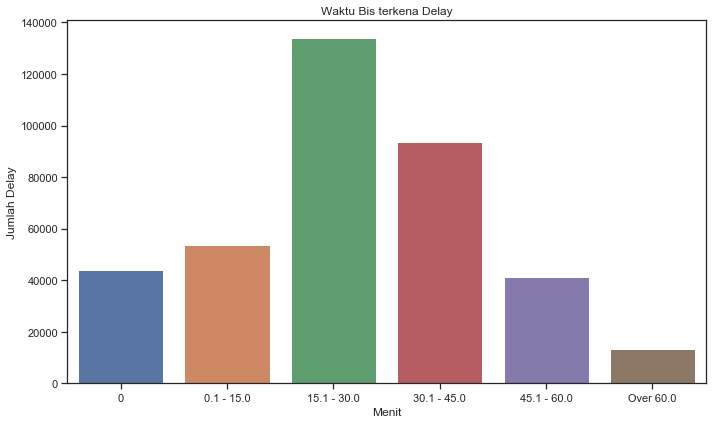

In [6]:
how = bus.groupby("Group_HLD").size()
lth = range(len(how))
plt.figure(figsize=(10,6))
sns.barplot(x=list(lth),y=how,data=bus)
plt.xticks(lth, how.index)
plt.title('Waktu Bis terkena Delay')
plt.ylabel('Jumlah Delay')
plt.xlabel('Menit')
plt.tight_layout()

# WIKO

In [7]:
#make a new column for publish date only to not lose the publish time.
date = []
for z in bus2['Occurred_On']:
    f = z.split('T')
    date.append(f[0])
bus2['date'] = date 

In [8]:
bus2['date'] = pd.to_datetime(bus2['date'])

In [9]:
bus2['year'] = bus2['date'].apply(lambda x: x.year)  
bus2['month'] = bus2['date'].apply(lambda x: x.month)  
bus2['day'] = bus2['date'].apply(lambda x: x.day)  

In [10]:
seasons = []
for x in bus2['month']:
    if (x >= 3) & (x <= 5):
        seasons.append('Spring')
    elif (x >= 6) & (x <= 8):
        seasons.append('Summer')
    elif (x >= 9) & (x <= 11):
        seasons.append('Fall')
    else:
        seasons.append('Winter')
bus2['seasons'] = seasons

In [11]:
onefive = bus2[bus2['year'] == 2015]
onesix = bus2[bus2['year'] == 2016]
oneseven = bus2[bus2['year'] == 2017]
oneeight = bus2[bus2['year'] == 2018]
onenine = bus2[bus2['year'] == 2019]

In [12]:
fallfilter = bus2[bus2['seasons'] == 'Fall']
summerfilter = bus2[bus2['seasons'] == 'Summer']
springfilter = bus2[bus2['seasons'] == 'Spring']
winterfilter = bus2[bus2['seasons'] == 'Winter']

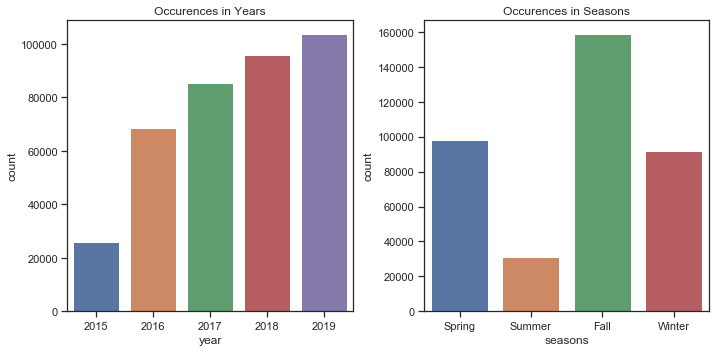

In [13]:
plt.figure(figsize =(15,5))
plt.subplot(1,3,1)
sns.countplot(x = 'year', data=bus2)
plt.title('Occurences in Years')
plt.subplot(1,3,2)
sns.countplot(x = 'seasons', data=bus2, order = ['Spring','Summer','Fall','Winter'])
plt.title('Occurences in Seasons')
plt.tight_layout()

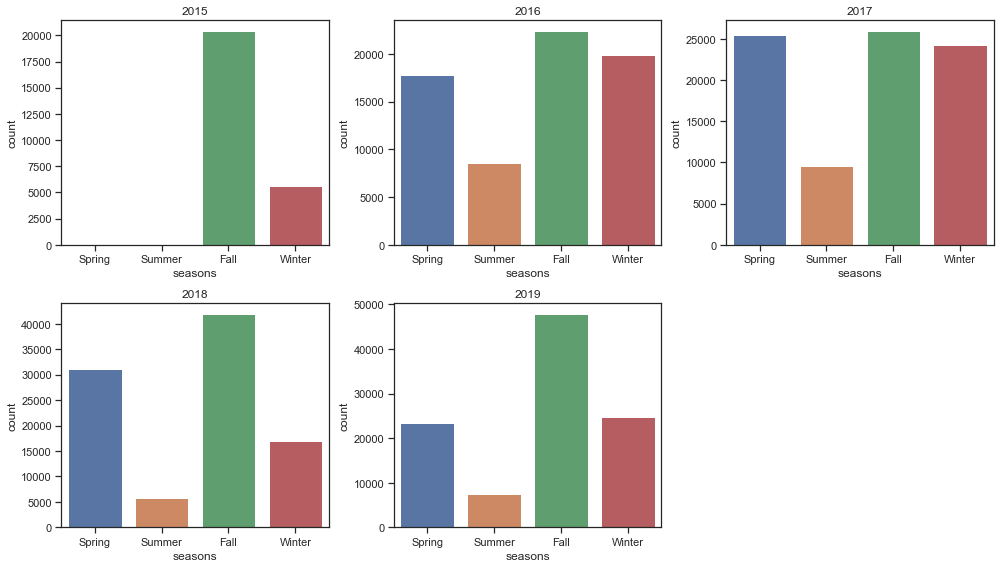

In [14]:
plt.figure(figsize =(14,8))
plt.subplot(2,3,1)
sns.countplot(x = 'seasons', data=onefive, order = ['Spring','Summer','Fall','Winter'])
plt.title('2015')
plt.subplot(2,3,2)
sns.countplot(x = 'seasons', data=onesix, order = ['Spring','Summer','Fall','Winter'])
plt.title('2016')
plt.subplot(2,3,3)
sns.countplot(x = 'seasons', data=oneseven, order = ['Spring','Summer','Fall','Winter'])
plt.title('2017')
plt.subplot(2,3,4)
sns.countplot(x = 'seasons', data=oneeight, order = ['Spring','Summer','Fall','Winter'])
plt.title('2018')
plt.subplot(2,3,5)
sns.countplot(x = 'seasons', data=onenine, order = ['Spring','Summer','Fall','Winter'])
plt.title('2019')
plt.tight_layout()

Text(0.5, 1.0, 'All Fall Problems')

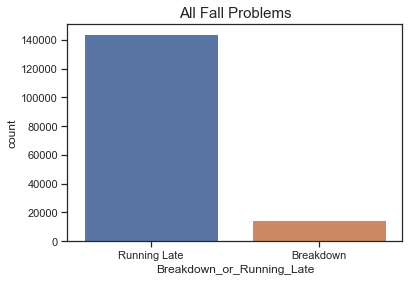

In [15]:
sns.countplot(x="Breakdown_or_Running_Late", data=fallfilter)
plt.title('All Fall Problems', fontsize=15)

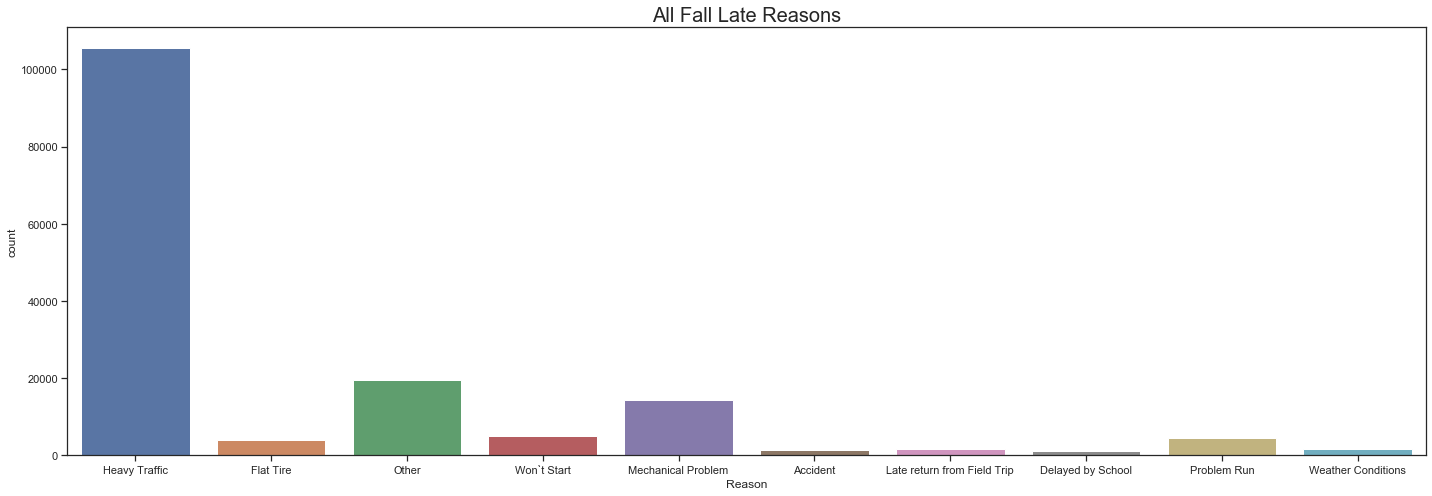

In [16]:
plt.figure(figsize =(20,7))
sns.countplot(x="Reason", data=fallfilter)
plt.title('All Fall Late Reasons', fontsize=20)
plt.tight_layout()

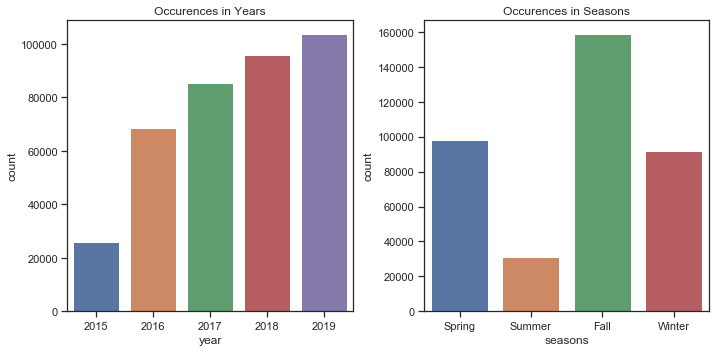

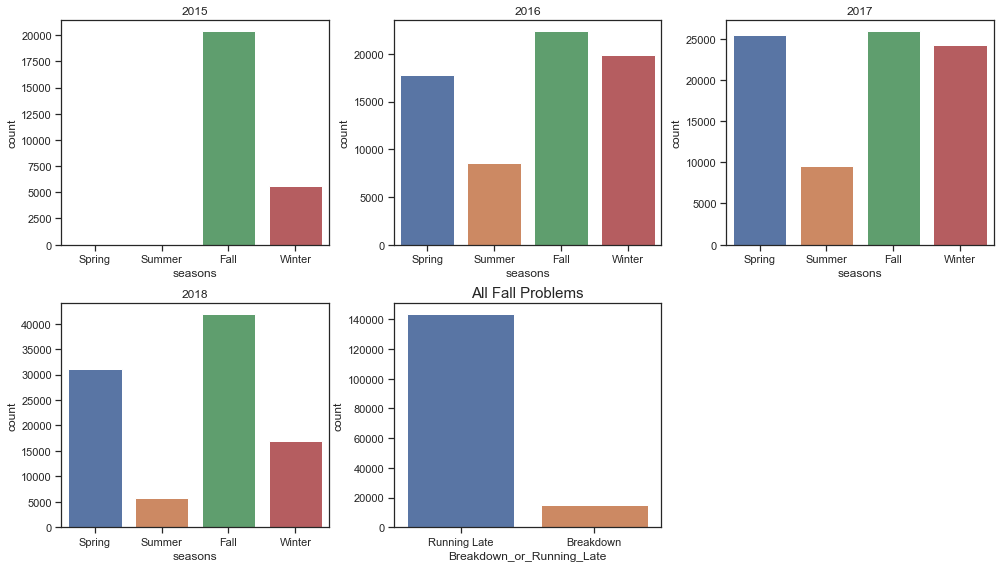

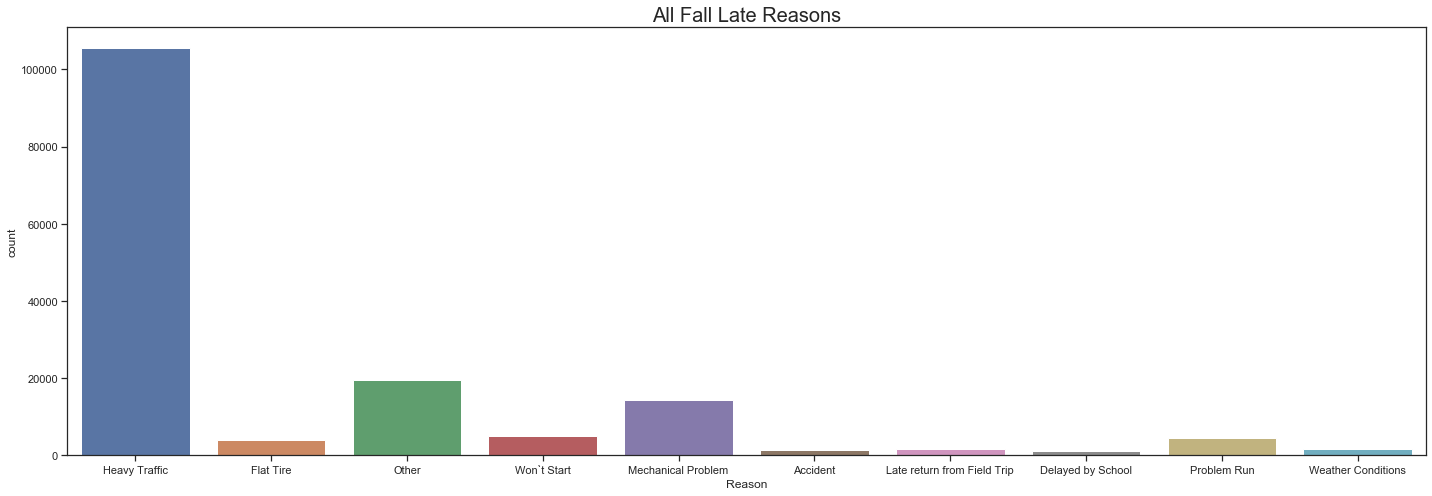

In [17]:
bus = pd.read_csv('bus-breakdown-and-delays.csv', low_memory = False)
bus2 = bus.copy()

#make a new column for publish date only to not lose the publish time.
date = []
for z in bus2['Occurred_On']:
    f = z.split('T')
    date.append(f[0])
bus2['date'] = date 

bus2['date'] = pd.to_datetime(bus2['date'])

bus2['year'] = bus2['date'].apply(lambda x: x.year)  
bus2['month'] = bus2['date'].apply(lambda x: x.month)  
bus2['day'] = bus2['date'].apply(lambda x: x.day)  

seasons = []
for x in bus2['month']:
    if (x >= 3) & (x <= 5):
        seasons.append('Spring')
    elif (x >= 6) & (x <= 8):
        seasons.append('Summer')
    elif (x >= 9) & (x <= 11):
        seasons.append('Fall')
    else:
        seasons.append('Winter')
bus2['seasons'] = seasons

onefive = bus2[bus2['year'] == 2015]
onesix = bus2[bus2['year'] == 2016]
oneseven = bus2[bus2['year'] == 2017]
oneeight = bus2[bus2['year'] == 2018]
onenine = bus2[bus2['year'] == 2019]

fallfilter = bus2[bus2['seasons'] == 'Fall']
summerfilter = bus2[bus2['seasons'] == 'Summer']
springfilter = bus2[bus2['seasons'] == 'Spring']
winterfilter = bus2[bus2['seasons'] == 'Winter']

plt.figure(figsize =(15,5))
plt.subplot(1,3,1)
sns.countplot(x = 'year', data=bus2)
plt.title('Occurences in Years')
plt.subplot(1,3,2)
sns.countplot(x = 'seasons', data=bus2, order = ['Spring','Summer','Fall','Winter'])
plt.title('Occurences in Seasons')
plt.tight_layout()

plt.figure(figsize =(14,8))
plt.subplot(2,3,1)
sns.countplot(x = 'seasons', data=onefive, order = ['Spring','Summer','Fall','Winter'])
plt.title('2015')
plt.subplot(2,3,2)
sns.countplot(x = 'seasons', data=onesix, order = ['Spring','Summer','Fall','Winter'])
plt.title('2016')
plt.subplot(2,3,3)
sns.countplot(x = 'seasons', data=oneseven, order = ['Spring','Summer','Fall','Winter'])
plt.title('2017')
plt.subplot(2,3,4)
sns.countplot(x = 'seasons', data=oneeight, order = ['Spring','Summer','Fall','Winter'])
plt.title('2018')
plt.subplot(2,3,5)
sns.countplot(x = 'seasons', data=onenine, order = ['Spring','Summer','Fall','Winter'])
plt.title('2019')
plt.tight_layout()

sns.countplot(x="Breakdown_or_Running_Late", data=fallfilter)
plt.title('All Fall Problems', fontsize=15)

plt.figure(figsize =(20,7))
sns.countplot(x="Reason", data=fallfilter)
plt.title('All Fall Late Reasons', fontsize=20)
plt.tight_layout()



# CATI

In [18]:
ny_bus = pd.read_csv('bus-breakdown-and-delays.csv', low_memory = False)

In [19]:
ny_bus['Occurred_On'] = pd.to_datetime(ny_bus['Occurred_On'],utc='none')
ny_bus['Created_On'] = pd.to_datetime(ny_bus['Created_On'])

In [20]:
ny_bus['Occured_Year'] = ny_bus['Occurred_On'].dt.year

In [21]:
ny_bus['Boro'].unique()

array(['New Jersey', 'Manhattan', 'Bronx', 'Westchester', 'Brooklyn',
       'Rockland County', 'Nassau County', nan, 'Queens', 'Staten Island',
       'All Boroughs', 'Connecticut'], dtype=object)

In [22]:
np.sort(ny_bus['Number_Of_Students_On_The_Bus'].unique())

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   65,   66,
         67,   69,   73,   76,   81,   82,   91,  102,  105,  109,  129,
        132,  138,  141,  145,  147,  156,  157,  158,  172,  198,  207,
        209,  246,  250,  258,  280,  317,  331,  356,  404,  500,  518,
        520,  536,  584,  588,  610,  612,  620,  623,  629,  637,  649,
        728,  822,  843,  863,  871, 1005, 1011, 1015, 1050, 1060, 1148,
       1155, 1156, 1165, 1177, 1186, 1204, 1240, 1245, 1254, 1258, 1268,
       1304, 1307, 1315, 1324, 1329, 1330, 1331, 1346, 1347, 1352, 1366,
       1371, 1378, 1382, 1384, 1400, 1401, 1402, 14

In [23]:
def boro_unknown(cols):
    if str(cols) == 'nan':
        cols = 'Unknown'
    return cols

ny_bus['Boro'] = ny_bus['Boro'].apply(boro_unknown)

In [24]:
def change_to_int (cols):
    if cols>90:
        cols = 91
    else:
        cols = int(cols)
    return cols

ny_bus['Number_Of_Students_On_The_Bus'] = ny_bus['Number_Of_Students_On_The_Bus'].apply(change_to_int)

In [25]:
ny_bus

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Occured_Year
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,New Jersey,...,11,Yes,No,Yes,2015-11-05T08:12:00.000,NaN,2015-11-05T08:12:14.000,Running Late,School-Age,2015
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,NaN,2015-11-05T08:13:34.000,Running Late,School-Age,2015
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00+00:00,2015-11-05 08:13:00,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,NaN,2015-11-05T08:13:22.000,Running Late,Pre-K,2015
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00+00:00,2015-11-05 08:14:00,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:04.000,Running Late,School-Age,2015
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05 08:13:00+00:00,2015-11-05 08:14:00,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:08.000,Running Late,School-Age,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379407,2018-2019,1565317,Pre-K/EI,2801,J47#5,Heavy Traffic,S047,2019-06-27 07:34:00+00:00,2019-06-27 07:37:00,Bronx,...,3,Yes,Yes,No,2019-06-27T07:37:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379408,2018-2019,1565318,Pre-K/EI,9349,5,Heavy Traffic,C465,2019-06-27 08:03:00+00:00,2019-06-27 08:26:00,Bronx,...,8,Yes,Yes,No,2019-06-27T08:26:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379409,2018-2019,1565319,Pre-K/EI,2616,NYM7,Heavy Traffic,E203,2019-06-27 11:40:00+00:00,2019-06-27 11:44:00,Bronx,...,5,Yes,Yes,No,2019-06-27T11:44:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379410,2018-2019,1565320,Special Ed AM Run,16412,K217,Other,"17333,17382,17448,17570,17669,17756",2019-06-27 13:18:00+00:00,2019-06-27 13:26:00,Brooklyn,...,0,Yes,Yes,No,2019-06-27T13:26:00.000,NaN,1900-01-01T00:00:00.000,Running Late,School-Age,2019


In [26]:
test = ny_bus[(ny_bus['Number_Of_Students_On_The_Bus'] <= 90) & (ny_bus['Boro'])]
test

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Occured_Year
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,New Jersey,...,11,Yes,No,Yes,2015-11-05T08:12:00.000,NaN,2015-11-05T08:12:14.000,Running Late,School-Age,2015
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,Manhattan,...,2,Yes,Yes,No,2015-11-05T08:12:00.000,NaN,2015-11-05T08:13:34.000,Running Late,School-Age,2015
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00+00:00,2015-11-05 08:13:00,Bronx,...,8,Yes,Yes,Yes,2015-11-05T08:13:00.000,NaN,2015-11-05T08:13:22.000,Running Late,Pre-K,2015
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00+00:00,2015-11-05 08:14:00,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:04.000,Running Late,School-Age,2015
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05 08:13:00+00:00,2015-11-05 08:14:00,Manhattan,...,6,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:08.000,Running Late,School-Age,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379407,2018-2019,1565317,Pre-K/EI,2801,J47#5,Heavy Traffic,S047,2019-06-27 07:34:00+00:00,2019-06-27 07:37:00,Bronx,...,3,Yes,Yes,No,2019-06-27T07:37:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379408,2018-2019,1565318,Pre-K/EI,9349,5,Heavy Traffic,C465,2019-06-27 08:03:00+00:00,2019-06-27 08:26:00,Bronx,...,8,Yes,Yes,No,2019-06-27T08:26:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379409,2018-2019,1565319,Pre-K/EI,2616,NYM7,Heavy Traffic,E203,2019-06-27 11:40:00+00:00,2019-06-27 11:44:00,Bronx,...,5,Yes,Yes,No,2019-06-27T11:44:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379410,2018-2019,1565320,Special Ed AM Run,16412,K217,Other,"17333,17382,17448,17570,17669,17756",2019-06-27 13:18:00+00:00,2019-06-27 13:26:00,Brooklyn,...,0,Yes,Yes,No,2019-06-27T13:26:00.000,NaN,1900-01-01T00:00:00.000,Running Late,School-Age,2019


In [27]:
ny_bus.groupby('Boro')['Number_Of_Students_On_The_Bus'].mean() ## ALL DATA

Boro
All Boroughs       2.052050
Bronx              3.423860
Brooklyn           2.470486
Connecticut        1.160338
Manhattan          1.023996
Nassau County      1.307367
New Jersey         2.118747
Queens             1.859906
Rockland County    1.430627
Staten Island      0.580308
Unknown            1.698062
Westchester        2.671520
Name: Number_Of_Students_On_The_Bus, dtype: float64

In [28]:
test.groupby('Boro')['Number_Of_Students_On_The_Bus'].mean() ##CLEAN NUMBER OF STUDENT ON THE BUS

Boro
All Boroughs       2.052050
Bronx              3.372674
Brooklyn           2.417899
Connecticut        1.160338
Manhattan          0.953388
Nassau County      1.253086
New Jersey         1.983806
Queens             1.806806
Rockland County    1.338477
Staten Island      0.557934
Unknown            1.617501
Westchester        2.535388
Name: Number_Of_Students_On_The_Bus, dtype: float64

In [29]:
affected_students_perYear = test.groupby('Occured_Year')['Number_Of_Students_On_The_Bus'].sum() ##CLEAN NUMBER OF STUDENT ON THE BUS 

Text(0.5, 1.0, 'Affected Students Based On Occured Year')

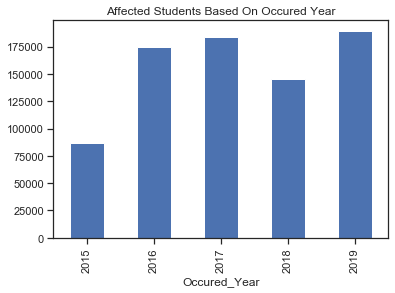

In [30]:
affected_students_perYear.plot(kind='bar')
plt.title('Affected Students Based On Occured Year')

In [31]:
affected_students_perYear

Occured_Year
2015     86676
2016    174311
2017    183640
2018    145095
2019    189521
Name: Number_Of_Students_On_The_Bus, dtype: int64

In [32]:
test['Number_Of_Students_On_The_Bus'].sum()

779243

In [33]:
affected_students_PerGrade = test.groupby('School_Age_or_PreK')['Number_Of_Students_On_The_Bus'].sum()

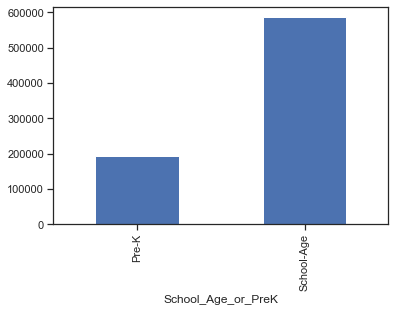

In [34]:
affected_students_PerGrade.plot(kind='bar')

In [35]:
affected_students_PerGrade

School_Age_or_PreK
Pre-K         192703
School-Age    586540
Name: Number_Of_Students_On_The_Bus, dtype: int64

### 0 number of student on the bus, yang berarti bus tersebut sudah breakdown/running late sebelum berhasil menjemput satupun murid-murid sekolah

In [36]:
az = ny_bus[(ny_bus['Number_Of_Students_On_The_Bus'] == 0)]
az

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Occured_Year
17,2015-2016,1227560,Special Ed AM Run,1205,P662,Heavy Traffic,29059,2015-11-05 06:45:00+00:00,2015-11-05 08:26:00,Unknown,...,0,Yes,Yes,Yes,2015-11-05T08:26:00.000,NaN,2015-11-05T08:26:22.000,Running Late,School-Age,2015
20,2015-2016,1227565,Special Ed AM Run,631,P464,Heavy Traffic,28908,2015-11-05 08:20:00+00:00,2015-11-05 08:30:00,Queens,...,0,Yes,No,No,2015-11-05T08:30:00.000,NaN,2015-11-05T08:30:48.000,Running Late,School-Age,2015
22,2015-2016,1227077,General Ed AM Run,2675,X2189,Other,10095,2015-11-04 07:04:00+00:00,2015-11-04 07:11:00,Bronx,...,0,Yes,Yes,No,2015-11-04T07:11:00.000,NaN,2015-11-04T07:11:53.000,Breakdown,School-Age,2015
24,2015-2016,1227566,Special Ed AM Run,2413,M935,Heavy Traffic,03004,2015-11-05 08:30:00+00:00,2015-11-05 08:31:00,Manhattan,...,0,Yes,Yes,Yes,2015-11-05T08:31:00.000,NaN,2015-11-05T08:31:31.000,Running Late,School-Age,2015
25,2015-2016,1227567,General Ed AM Run,27704,M1227,Heavy Traffic,02267,2015-11-05 20:20:00+00:00,2015-11-05 08:33:00,Manhattan,...,0,Yes,No,No,2015-11-05T08:33:00.000,NaN,2015-11-05T08:35:03.000,Running Late,School-Age,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379400,2018-2019,1565310,Special Ed PM Run,1521,N701,Heavy Traffic,75907,2019-06-26 15:05:00+00:00,2019-06-26 15:12:00,Nassau County,...,0,Yes,Yes,Yes,2019-06-26T15:12:00.000,NaN,1900-01-01T00:00:00.000,Running Late,School-Age,2019
379402,2018-2019,1565312,Pre-K/EI,52204,B0946A,Mechanical Problem,E052A,2019-06-27 07:15:00+00:00,2019-06-27 07:29:00,Brooklyn,...,0,Yes,Yes,Yes,2019-06-27T07:29:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379403,2018-2019,1565313,Pre-K/EI,4002,B0961A,Other,E052A,2019-06-27 07:15:00+00:00,2019-06-27 07:31:00,Brooklyn,...,0,Yes,Yes,Yes,2019-06-27T07:31:00.000,NaN,1900-01-01T00:00:00.000,Running Late,Pre-K,2019
379410,2018-2019,1565320,Special Ed AM Run,16412,K217,Other,"17333,17382,17448,17570,17669,17756",2019-06-27 13:18:00+00:00,2019-06-27 13:26:00,Brooklyn,...,0,Yes,Yes,No,2019-06-27T13:26:00.000,NaN,1900-01-01T00:00:00.000,Running Late,School-Age,2019


### BUS COMPANY YANG SERING TIDAK BERHASIL MENJEMPUT SATU PUN MURID SEKOLAH (COUNT BY PER OCCURENCE)

In [37]:
an = az['Bus_Company_Name'].value_counts().head(30)
an

LEESEL TRANSPORTATION CORP (B2192)     38282
BORO TRANSIT, INC.                     14477
PIONEER TRANSPORTATION CORP            13914
LITTLE RICHIE BUS SERVICE              11541
RELIANT TRANSPORTATION, INC (B2321)    10102
LEESEL TRANSP CORP (B2192)              9539
PIONEER TRANSPORTATION CO               8900
SNT BUS INC                             8639
LOGAN BUS COMPANY INC.                  7241
RELIANT TRANS, INC. (B232               7062
NEW DAWN TRANSIT, LLC (B2321)           5833
LEESEL TRANSP CORP (B2192               5343
VAN TRANS LLC (B2192)                   5152
NEW DAWN TRANSIT, LLC (B2               4716
HOYT TRANSPORTATION CORP.               4419
L & M BUS CORP.                         4253
JOFAZ TRANSPORTATION INC.               4246
G.V.C., LTD.                            3870
RELIANT TRANS, INC. (B2321)             3638
LITTLE LISA BUS CO. INC.                3493
G.V.C. LTD. (B2192)                     3229
GRANDPA`S BUS CO., INC.                 3154
LORINDA EN

Text(0.5, 1.0, '0 Number of Student on The Bus per-Occurence')

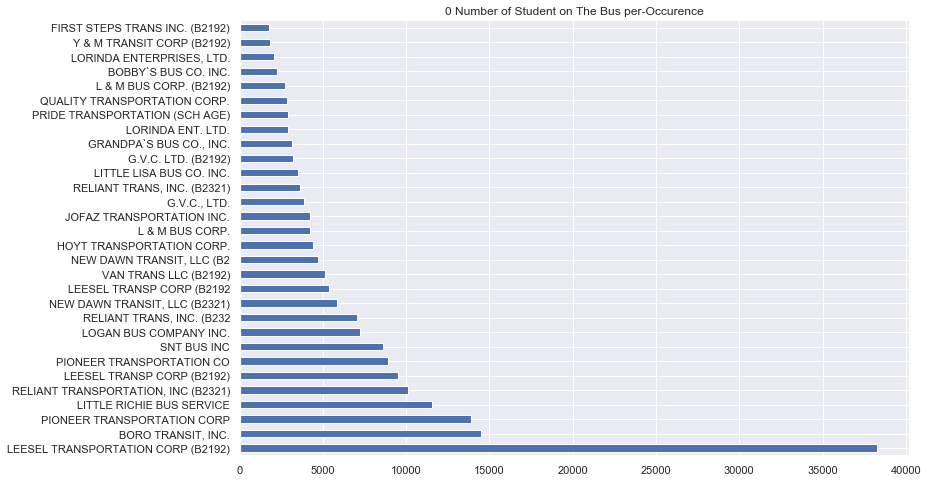

In [71]:
plt.figure(figsize=(12,8))
an.plot(kind = 'barh')
plt.title('0 Number of Student on The Bus per-Occurence')

In [ ]:
test['Reason'].sum()

In [40]:
ny_bus['Number_Of_Students_On_The_Bus'].value_counts()

0     233779
2      21658
1      21388
3      20293
4      16810
       ...  
67         1
59         1
58         1
82         1
56         1
Name: Number_Of_Students_On_The_Bus, Length: 73, dtype: int64

# STEVANO

## LEAST RELIABLE SCHOOL BUS COMPANY

In [41]:
ny_busb = ny_bus[ny_bus['Breakdown_or_Running_Late'] == 'Breakdown']

In [42]:
len(ny_busb)

38639

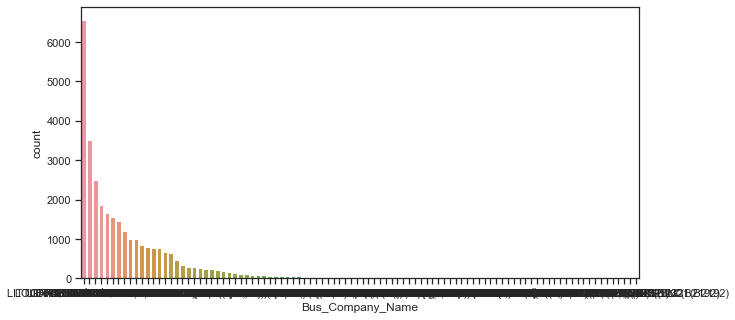

In [43]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x = ny_busb[ny_busb['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'],  order = ny_busb[ny_busb['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'].value_counts().index)
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [44]:
ny_busb['Bus_Company_Name'].value_counts().head(15)

LITTLE RICHIE BUS SERVICE              6594
LOGAN BUS COMPANY INC.                 3519
LITTLE LISA BUS CO. INC.               2507
RELIANT TRANS, INC. (B232              2011
GRANDPA`S BUS CO., INC.                1883
BORO TRANSIT, INC.                     1867
JOFAZ TRANSPORTATION INC.              1566
LORINDA ENT. LTD.                      1457
SNT BUS INC                            1324
BOBBY`S BUS CO. INC.                   1220
PRIDE TRANSPORTATION (SCH AGE)         1144
HOYT TRANSPORTATION CORP.              1107
QUALITY TRANSPORTATION CORP.            896
NEW DAWN TRANSIT, LLC (B2321)           888
RELIANT TRANSPORTATION, INC (B2321)     851
Name: Bus_Company_Name, dtype: int64

## School, Parents, OPT Notified

Text(0.5, 1.0, 'Have You Alerted OPT')

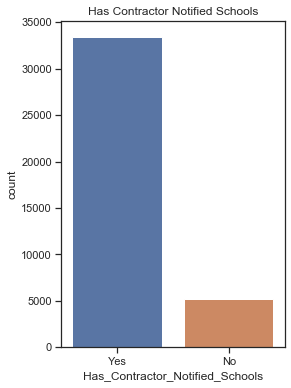

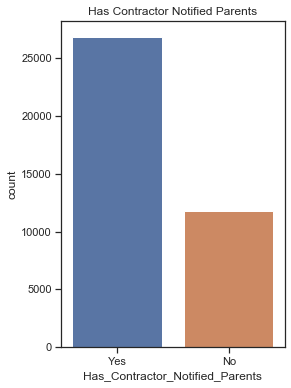

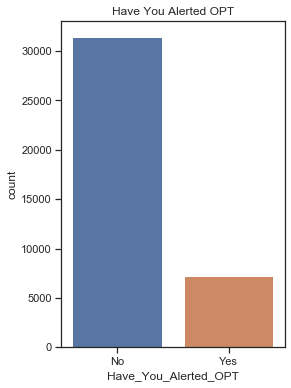

In [45]:
plt.figure(figsize=(4,6))
sns.countplot(x = ny_busb['Has_Contractor_Notified_Schools'])
plt.title('Has Contractor Notified Schools')

plt.figure(figsize=(4,6))
sns.countplot(x = ny_busb['Has_Contractor_Notified_Parents'])
plt.title('Has Contractor Notified Parents')

plt.figure(figsize=(4,6))
sns.countplot(x = ny_busb['Have_You_Alerted_OPT'])
plt.title('Have You Alerted OPT')

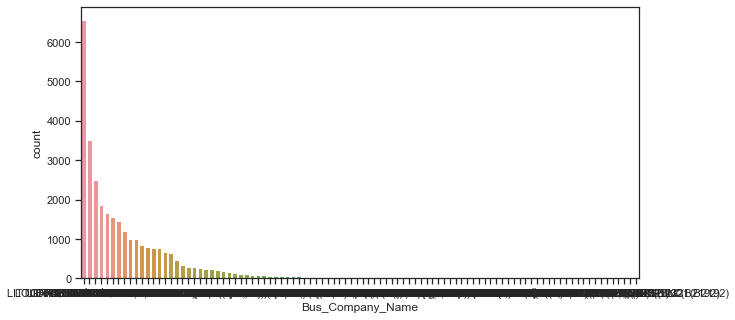

In [46]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x = ny_busb[ny_busb['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'],  order = ny_busb[ny_busb['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'].value_counts().index)

In [47]:
ny_busb[ny_busb['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'].value_counts().head(15)

LITTLE RICHIE BUS SERVICE         6571
LOGAN BUS COMPANY INC.            3508
LITTLE LISA BUS CO. INC.          2502
GRANDPA`S BUS CO., INC.           1864
BORO TRANSIT, INC.                1667
JOFAZ TRANSPORTATION INC.         1553
LORINDA ENT. LTD.                 1455
BOBBY`S BUS CO. INC.              1203
HOYT TRANSPORTATION CORP.         1007
SNT BUS INC                        989
LORINDA ENTERPRISES, LTD.          845
QUALITY TRANSPORTATION CORP.       811
Y & M TRANSIT CORP (B2192)         779
LORISSA BUS SERVICE INC.           764
PRIDE TRANSPORTATION (SCH AGE)     681
Name: Bus_Company_Name, dtype: int64

In [48]:
ny_bus[ny_bus['Have_You_Alerted_OPT']=='No']['Bus_Company_Name'].value_counts().head(20)

LEESEL TRANSPORTATION CORP (B2192)    42528
G.V.C., LTD.                          19288
PIONEER TRANSPORTATION CORP           15758
BORO TRANSIT, INC.                    14573
LITTLE RICHIE BUS SERVICE             13623
PIONEER TRANSPORTATION CO             11625
NEW DAWN TRANSIT, LLC (B2             10249
LEESEL TRANSP CORP (B2192             10018
LEESEL TRANSP CORP (B2192)             9936
HOYT TRANSPORTATION CORP.              9082
LOGAN BUS COMPANY INC.                 8649
ALLIED TRANSIT CORP.                   7418
SNT BUS INC                            7415
SELBY TRANSPORTATION                   5914
NEW DAWN TRANSIT, LLC (B2321)          4971
JOFAZ TRANSPORTATION INC.              4946
EMPIRE CHARTER SERVICE INC             4520
EMPIRE STATE BUS CORP.                 4291
G.V.C. LTD. (B2192)                    3982
LITTLE LISA BUS CO. INC.               3856
Name: Bus_Company_Name, dtype: int64

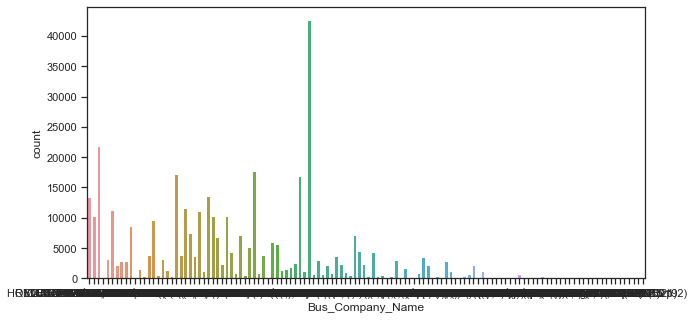

In [49]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x = ny_bus['Bus_Company_Name'])

In [50]:
ny_bus['Bus_Company_Name'].value_counts().head(15)

LEESEL TRANSPORTATION CORP (B2192)     42687
G.V.C., LTD.                           21771
PIONEER TRANSPORTATION CORP            17776
BORO TRANSIT, INC.                     17228
RELIANT TRANSPORTATION, INC (B2321)    16902
LITTLE RICHIE BUS SERVICE              13662
RELIANT TRANS, INC. (B232              13453
PIONEER TRANSPORTATION CO              11654
LEESEL TRANSP CORP (B2192              11208
VAN TRANS LLC (B2192)                  11193
LEESEL TRANSP CORP (B2192)             10379
HOYT TRANSPORTATION CORP.              10361
NEW DAWN TRANSIT, LLC (B2              10312
SNT BUS INC                             9647
LOGAN BUS COMPANY INC.                  8671
Name: Bus_Company_Name, dtype: int64

In [51]:
ny_bus['Route_Number'].value_counts().head(10)

1       4278
2       3151
3       2659
5       2654
4       1548
6       1204
7        953
8        747
M978     543
M261     538
Name: Route_Number, dtype: int64

In [52]:
# len(ny_bus[ny_bus['Number_Of_Students_On_The_Bus']==0])
# ny_bus[ny_bus['Schools_Serviced']=='02655,02667,02908']
# ny_bus['Schools_Serviced'][42541].split(',')

Banyaknya Rute yang diambil

In [53]:
gero=[]
for i in ny_bus['Schools_Serviced'].values:
    i = str(i)
    a = len(i.split(','))
    gero.append(a)
ny_bus['Schools_Serviced_Count']= pd.Series(gero)
ny_bus.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK,Occured_Year,Schools_Serviced_Count
0,2015-2016,1227538,Special Ed AM Run,2621,J711,Heavy Traffic,75003,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,New Jersey,...,Yes,No,Yes,2015-11-05T08:12:00.000,NaN,2015-11-05T08:12:14.000,Running Late,School-Age,2015,1
1,2015-2016,1227539,Special Ed AM Run,1260,M351,Heavy Traffic,06716,2015-11-05 08:10:00+00:00,2015-11-05 08:12:00,Manhattan,...,Yes,Yes,No,2015-11-05T08:12:00.000,NaN,2015-11-05T08:13:34.000,Running Late,School-Age,2015,1
2,2015-2016,1227540,Pre-K/EI,418,3,Heavy Traffic,C445,2015-11-05 08:09:00+00:00,2015-11-05 08:13:00,Bronx,...,Yes,Yes,Yes,2015-11-05T08:13:00.000,NaN,2015-11-05T08:13:22.000,Running Late,Pre-K,2015,1
3,2015-2016,1227541,Special Ed AM Run,4522,M271,Heavy Traffic,02699,2015-11-05 08:12:00+00:00,2015-11-05 08:14:00,Manhattan,...,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:04.000,Running Late,School-Age,2015,1
4,2015-2016,1227542,Special Ed AM Run,3124,M373,Heavy Traffic,02116,2015-11-05 08:13:00+00:00,2015-11-05 08:14:00,Manhattan,...,No,No,No,2015-11-05T08:14:00.000,NaN,2015-11-05T08:14:08.000,Running Late,School-Age,2015,1


In [54]:
ny_bus['Schools_Serviced_Count'].value_counts()

1     223835
2      71900
3      47754
4      21866
5       8588
6       2868
7       1279
8        674
9        352
10       156
11        92
12        27
13        18
14         3
Name: Schools_Serviced_Count, dtype: int64

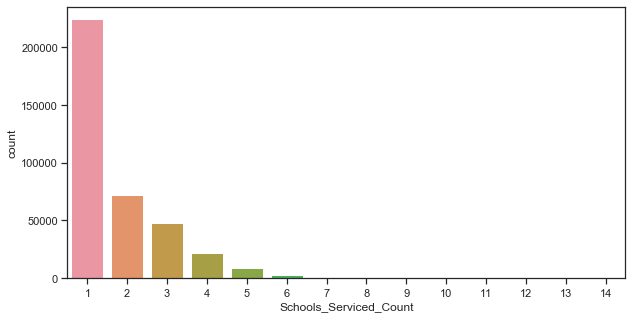

In [55]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x = ny_bus['Schools_Serviced_Count'])

# DIUS

## Accidents

In [56]:
buskotor = pd.read_csv('bus-breakdown-and-delays.csv', low_memory = False)
bus=buskotor[~(buskotor['Boro'].isna())].copy()

In [57]:
def minutes(x): # mencari angka berurut untuk diubah ke menit
    flag = None
    num_list = list()
    num = str()
    for i in str(x):         
        if i.isnumeric():
            flag = 1
            num += i
        else:
            if num:
                num_list.append(num)
            flag = 0
            num = ''
    return int(num_list[-1]) if num_list else 0

bus['How_Long_Delayed'] = bus.How_Long_Delayed.fillna(0) # NaN sama dengan 0
bus['How_Long_Delayed'] = bus.How_Long_Delayed.str.lower()
bus['HLD'] = pd.to_numeric(bus.How_Long_Delayed, errors='coerce') # membuat column baru bernama HLD

bus.loc[
    bus.How_Long_Delayed.str.contains('m|-|in|/', na=False), 
    'HLD'
] = bus.How_Long_Delayed.apply(minutes) # apabila di column How_Long_Delayed terdapat string (m,-,in,/) maka apply minutes
bus.loc[bus.How_Long_Delayed.str.contains('hr|hour', na=False), 'HLD'] = 60 # apabila ada string (hr,hour)
bus.loc[bus.HLD.isna(), 'HLD'] = 0 # error atau NaN sama dengan 0
bus.loc[bus.Breakdown_or_Running_Late =='Breakdown', 'HLD'] = 0 # bus yang breakdown tidak dianggap delay (sama dengan 0)

Text(0.5, 1.0, 'Accident')

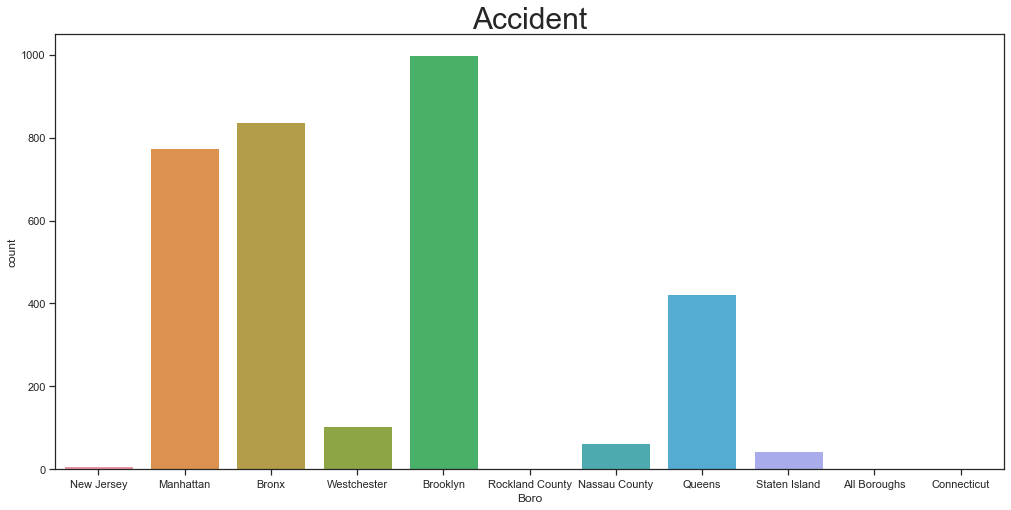

In [58]:
plt.figure(figsize=(17,8))
sns.countplot(data=bus[bus['Reason']=='Accident'], x='Boro', order=bus['Boro'].unique())
# sns.set(style='darkgrid')
plt.title('Accident', fontsize=30)

In [59]:
rockland=bus[(bus['Boro']=='Rockland County')].copy()
nj=bus[bus['Boro']=='New Jersey'].copy()
connect=bus[bus['Boro']=='Connecticut'].copy()
borough=bus[bus['Boro']=='All Boroughs'].copy()
isi=[rockland,nj,connect,borough]
isiisi=['ROCKLAND COUNTY','NEW JERSEY','CONNECTICUT','ALL BOROUGHS']

In [60]:
def try_normal(data):
    result={'Anderson':{i:j for i,j in zip(anderson(data)[2], anderson(data)[1])}, 'Shapiro':shapiro(data)[1],
           'K^2':normaltest(data)[1]}
    result['Anderson']['stat']=anderson(data)[0]
    return result

In [61]:
for i,j in zip(isi,isiisi):
    a=try_normal(i['HLD'])
    print(j)
    print('Anderson : {}'.format(a['Anderson']))
    print('Shapiro : {}'.format(a['Shapiro']))
    print('K^2 : {}'.format(a['K^2']))
    print('\n')

ROCKLAND COUNTY
Anderson : {15.0: 0.574, 10.0: 0.653, 5.0: 0.784, 2.5: 0.914, 1.0: 1.088, 'stat': 20.78017698918859}
Shapiro : 1.2530871211625732e-19
K^2 : 9.569869380614886e-08


NEW JERSEY
Anderson : {15.0: 0.575, 10.0: 0.655, 5.0: 0.785, 2.5: 0.916, 1.0: 1.09, 'stat': 672.4323598064075}
Shapiro : 0.0
K^2 : 0.0


CONNECTICUT
Anderson : {15.0: 0.567, 10.0: 0.645, 5.0: 0.774, 2.5: 0.903, 1.0: 1.074, 'stat': 7.715895937442099}
Shapiro : 5.436256445001675e-10
K^2 : 0.0007647039589004447


ALL BOROUGHS
Anderson : {15.0: 0.572, 10.0: 0.652, 5.0: 0.782, 2.5: 0.912, 1.0: 1.085, 'stat': 22.3224844050078}
Shapiro : 3.9904115572928935e-19
K^2 : 3.435821567837931e-13




Dari data How long delayed tiap kota memang tidak normal, karena ketiga data waktu delay ini tidak normal, maka akan dilakukan test perbedaan non parametric dengan uji kruskal 

In [62]:
kruskal(rockland['HLD'],nj['HLD'],connect['HLD'], borough['HLD'])

KruskalResult(statistic=120.85051767823629, pvalue=5.0612514169801387e-26)

Uji ini menunjukkan terdapat perbedaan data waktu delay tiap kotanya, Akan dilihat perbedaan apa saja yang dimiliki. Dalam hal ini akan digunakkan uji pairwise tukey

In [63]:
idx=bus[(bus['Boro']!='Rockland County') & (bus['Boro']!='Connecticut')& (bus['Boro']!='All Boroughs') & (bus['Boro']!='New Jersey')].index
diff=bus.drop(idx).reset_index(drop=True)
pairwise_ttests(data=diff, dv='HLD', between='Boro', parametric=False)

,Contrast,A,B,Paired,Parametric,U-val,Tail,p-unc,hedges
0,Boro,New Jersey,Rockland County,False,False,1025458.0,two-sided,3.549356e-03,0.064
1,Boro,New Jersey,All Boroughs,False,False,803441.5,two-sided,4.243417e-27,0.081
2,Boro,New Jersey,Connecticut,False,False,266093.5,two-sided,5.904486e-04,0.062
3,Boro,Rockland County,All Boroughs,False,False,375521.5,two-sided,5.730165e-14,0.403
4,Boro,Rockland County,Connecticut,False,False,123179.5,two-sided,9.645759e-02,0.136
5,Boro,All Boroughs,Connecticut,False,False,62139.5,two-sided,5.188184e-05,-0.309


Text(0.5, 1.0, 'Delay time based on Boro')

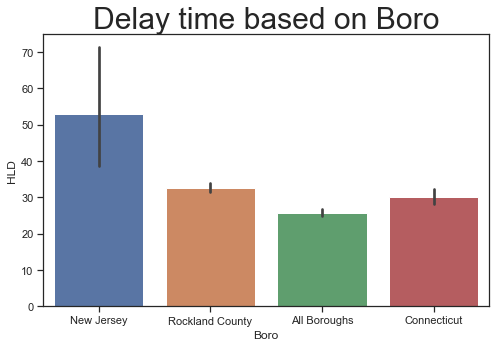

In [64]:
plt.figure(figsize=(8,5))
sns.barplot(data=diff, x='Boro', y='HLD')
plt.title('Delay time based on Boro', fontsize=30)
# sns.set(style='darkgrid')

(0, 500)

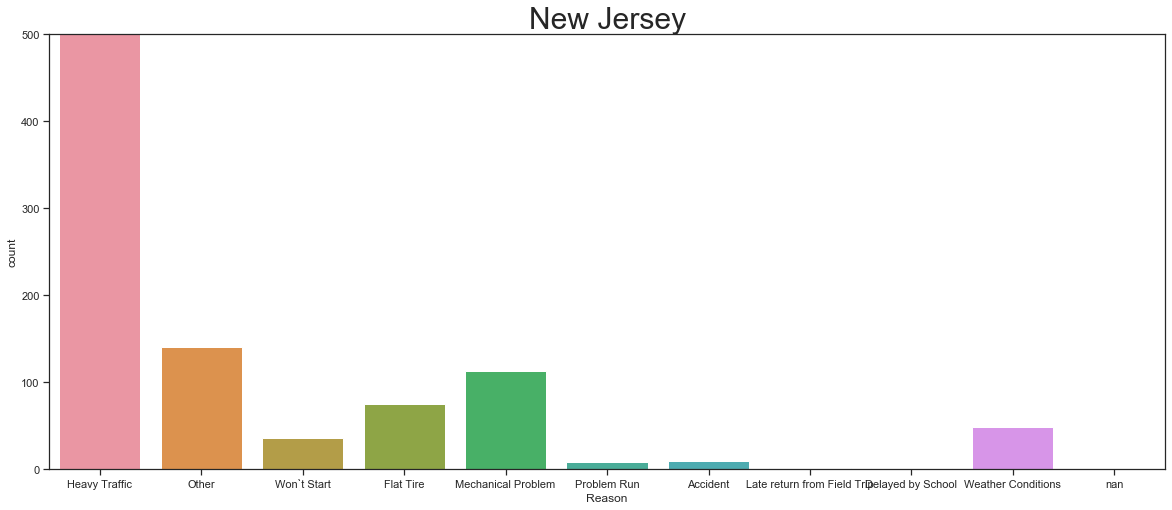

In [65]:
plt.figure(figsize=(20,8))
sns.countplot(diff[diff['Boro']=='New Jersey']['Reason'], order=bus['Reason'].unique())
# sns.set(style='darkgrid')
plt.title('New Jersey', fontsize=30)
plt.ylim(0,500)

(0, 500)

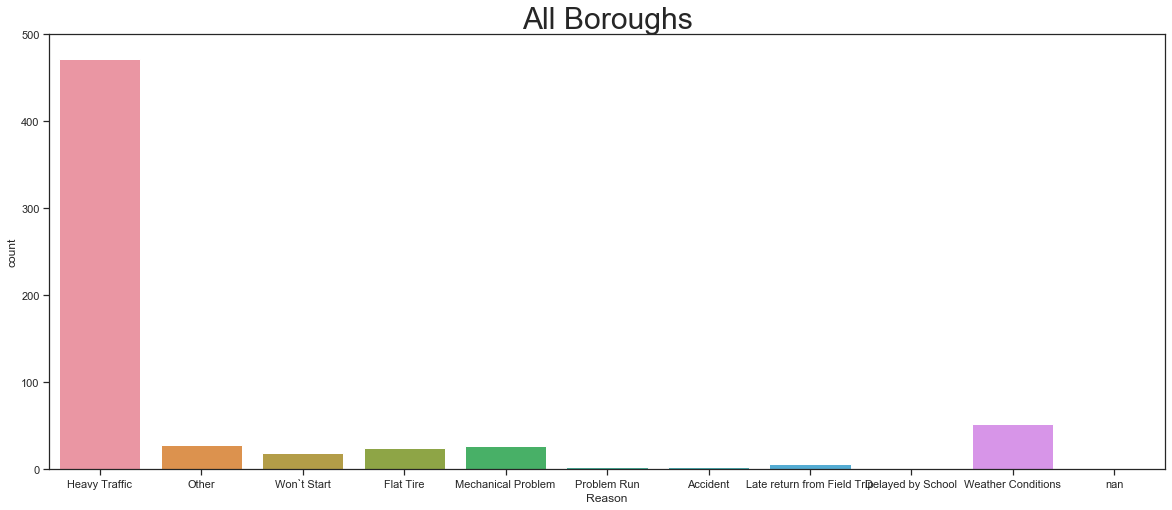

In [66]:
plt.figure(figsize=(20,8))
sns.countplot(diff[diff['Boro']=='All Boroughs']['Reason'], order=bus['Reason'].unique())
sns.set(style='darkgrid')
plt.title('All Boroughs', fontsize=30)
plt.ylim(0,500)

(0, 500)

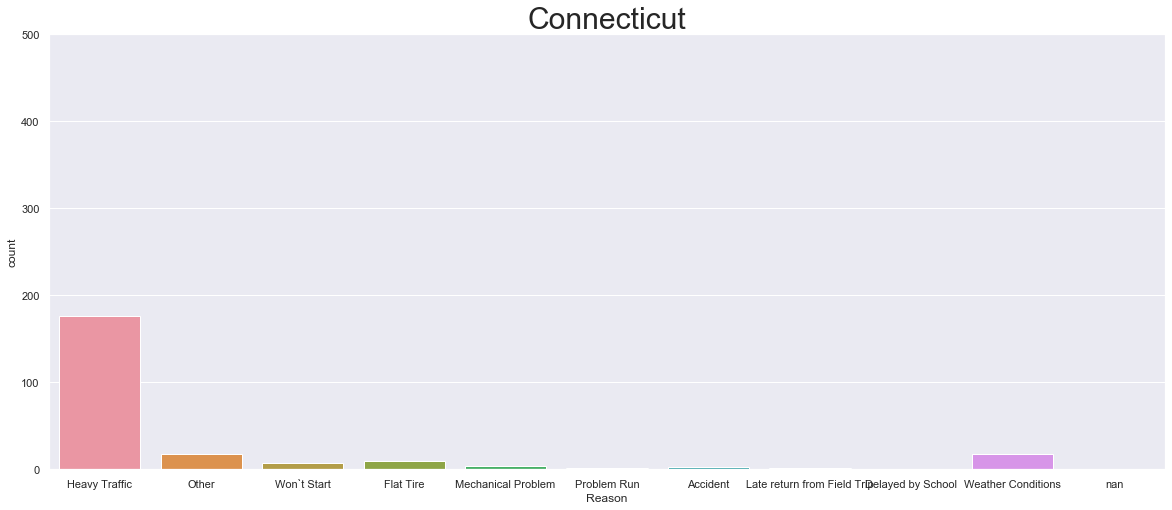

In [67]:
plt.figure(figsize=(20,8))
sns.countplot(diff[diff['Boro']=='Connecticut']['Reason'], order=bus['Reason'].unique())
sns.set(style='darkgrid')
plt.title('Connecticut', fontsize=30)
plt.ylim(0,500)

Text(0.5, 1.0, 'Rockland County')

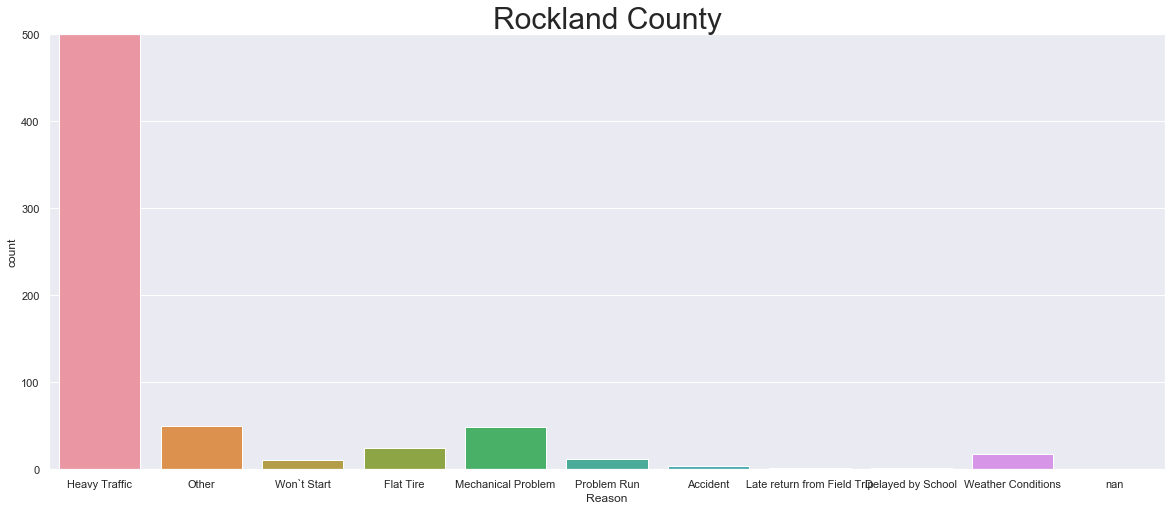

In [68]:
plt.figure(figsize=(20,8))
sns.countplot(diff[diff['Boro']=='Rockland County']['Reason'], order=bus['Reason'].unique())
sns.set(style='darkgrid')
plt.ylim(0,500)
plt.title('Rockland County', fontsize=30)

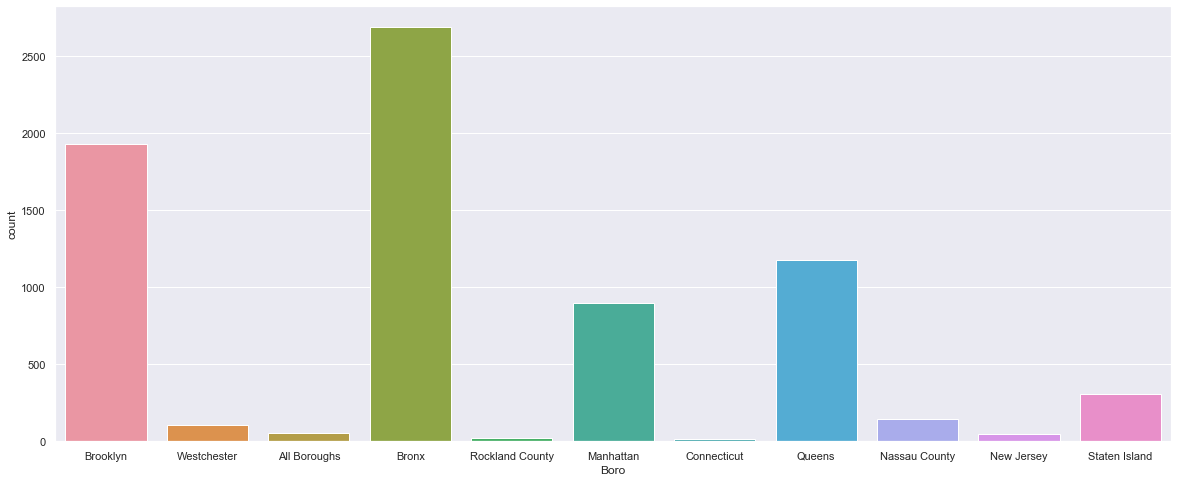

In [69]:
plt.figure(figsize=(20,8))
sns.countplot(bus[bus['Reason']=='Weather Conditions']['Boro'])

Manhattan macet karena terdapat tempat-tempat wisata seperti Empire state building, NY times square, central park. Kemudian diatasnya ada bronx makanya bronx jg kena macet. Manhattannya jg nyambung oleh jembatan dengan brooklyn dan staten island, sebelah kanan brooklyn ada queens dan nassau county

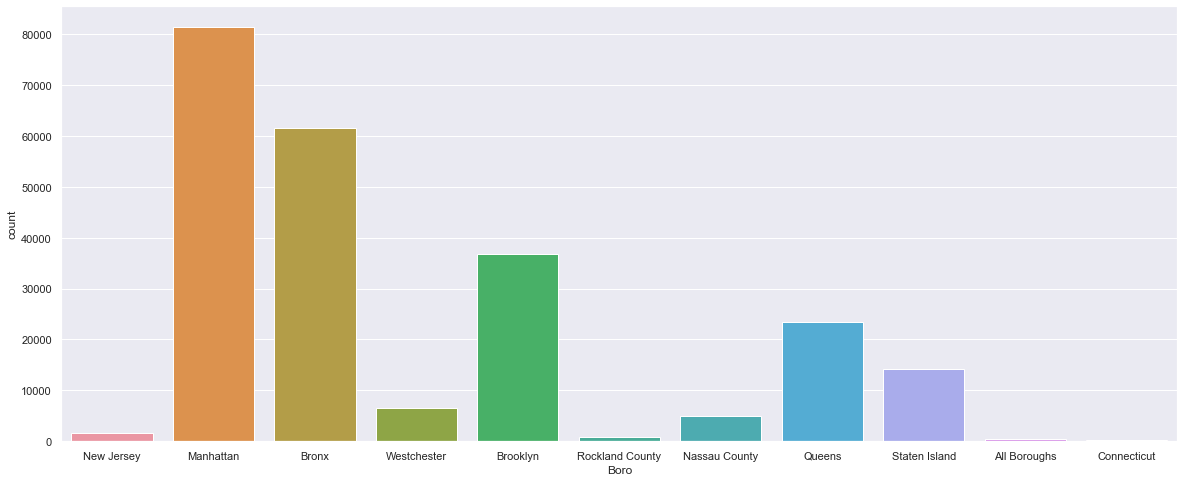

In [70]:
plt.figure(figsize=(20,8))
sns.countplot(bus[bus['Reason']=='Heavy Traffic']['Boro'])